# Do the average temperature and certain months of the year affect the number of bike trips from San Francisco Bay Area bike share?

## Introduction

Summer is the most favourable season for outdoor activities, such as swimming, kayaking, and biking. San Francisco Bay Area is undoubtedly one of the hottest places in America to spend your vacations. This study aims to examine how the number of bike trips per day varies according to the temperature and month of the year using the San Francisco Bay Area bike share data from August 2013 to August 2015. We selected the number of trips per day as the response variable to answer our research question. Predictor variables to study concerning the number of trips per day are the average temperature (measured in Fahrenheit) and the month of the start day of the trip. Since warmer temperatures accompany summer and winter generally lead to severe weather conditions, month and temperature can be said to be closely related. From a previous study conducted by Mark Martinez, he focused on examining the effect of weather on daily bike rentals from Citi Bike, a bike-share system in New York City. He ran four multiple regressions, using temperature, precipitation, wind speed, snowfall, and month as explanatory variables. While fixing other variables fixed, every unit higher in precipitation, windspeed, or snowfall adversely impacts the ridership. The temperature exhibited a quadratic relationship with ridership. When the temperature is low, ridership rises as the temperature is one Fahrenheit higher, and when the temperature is high, ridership slowly decreases as the temperature gets higher. The highest ridership occurred from August to October, around summertime, and it is much higher than in January. All models have an R-squared of more than 0.7, indicating that predictors explain 70 percent of the variation in ridership in the model (2017). Another research about bike share in Washington, DC, also focused on the weather impact on daily trips. The temperature was used as a categorical variable with a 10°F increment starting from 10°F to 100°F. The number of trips rises from 10°F (-12.22°C) to less than 90°F (32.22°C) and diminishes when reaching 90°F (Gebhart & Noland, 2014). Two studies have revealed a non-linear relationship between the temperature and the number of trips, and it seems that a moderate temperature is more suitable for a bike trip. A study of the effect of introducing a single trip bike share fare of $2 in Washington, DC, discovered an increase of 41\% in the ridership. This large percentage informed that the single trip fare option significantly elevated the bike share usage (Kaviti et al., 2018).

We will also build linear regression models using temperature and month as the explanatory variables, including weekday and weekend subgroups and monthly oil prices, and examine the distinction between years. The weather dataset we have ranged from 39.2°F (4°C) to 80.6°F (27°C), and it is a continuous variable in the model. In contrast to investigating the impact of global warming or weather conditions, our motivation is to seek how the variation in month and temperature affect the popularity of bike-share usage. We will generate two maps of the average of the response variable for 2013 and 2015 by San Francisco Bay Area zip codes. To find out where the frequency of bike share usage is the most. Visualizations of the variables' distribution and relation will be presented, either grouped by year, weekdays, weekends, or simply ungrouped. Monthly oil price data between 2013 to 2015 in California were gathered through HTML-based web scraping from the Energy Information Administration's official website. We analyzed the relationship between the dependent variable and the newly added data. The conjecture is that the months with higher gasoline price has higher bike share usage. The response and predictor variables are obtained by grouping and merging the raw datasets to record information on a daily trip, weather, and stations.

# Project One

## Data Cleaning

In [832]:
import pandas as pd
import numpy as np
import qeds
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

%matplotlib inline
qeds.themes.mpl_style();

# Read the weather data
weather = pd.read_csv("/Users/rachelchen/Desktop/UofT/\
ECO225/ECO225Project/Data/archive/weather.csv")
weather["date"] = pd.to_datetime(weather["date"])

In [833]:
# Check for missing data in average temperature
weather["mean_temperature_f"].isnull().sum()

4

There are missing data in the variable mean temperature, so we want to remove those observations.

In [834]:
# Remove the missing data for mean temperature
weather = weather.dropna(subset=["mean_temperature_f"])

In [835]:
# Check for duplicate values in date
weather.duplicated(subset="date").sum()

2928

The variable date has 2928 duplicates. We chose to take the average of mean temperature on a specific day.

In [836]:
# Modify the weather data to make sure the mean temperature variable is consistent
weather = weather.groupby("date").mean()
weather = weather[["mean_temperature_f"]]

In [837]:
# Read the trip data
trip = pd.read_csv("/Users/rachelchen/Desktop/UofT/\
ECO225/ECO225Project/Data/archive/trip.csv")

# Remove time in start_date to match with the weather data
trip["start_date_normalize"] = pd.to_datetime(trip["start_date"]
                                             ).dt.normalize()

In [838]:
# Group the dataset by date and calculate the number of trips per day
g_trip = trip.groupby("start_date_normalize").count()
g_trip["num_trip"] = g_trip["start_date"]
g_trip = g_trip.reset_index()
g_trip = g_trip[["start_date_normalize", "num_trip"]]

In [839]:
# Merge the two dataset so the unit of observation is day.
trip_weather = pd.merge(g_trip, weather, 
                        left_on = "start_date_normalize", 
                        right_on = "date", 
                        how = "left")

In [840]:
# Create the variable month which is the month of the start date 
# of the trip
for row in trip_weather.iterrows():
    index_value, column_values = row
    clean_number = column_values["start_date_normalize"].month
    trip_weather.at[index_value, "month"] = clean_number
    
trip_weather["month"] = trip_weather.month.astype(int)

### Final Dataset

**Below is an idea of the final dataset that we will be using to do the analysis.**

In [841]:
trip_weather.head()

,start_date_normalize,num_trip,mean_temperature_f,month
0,2013-08-29,748,70.4,8
1,2013-08-30,714,73.0,8
2,2013-08-31,640,68.0,8
3,2013-09-01,706,70.0,9
4,2013-09-02,661,70.8,9


There are four variables in the dataset: the start date of the trip, the number of trips, the average temperature, and the month.

## Summary Statistics

In [842]:
# Summary table of variables number of trips, average temperature, and month.
df = pd.DataFrame([trip_weather["num_trip"].describe(),
                   trip_weather["mean_temperature_f"].describe(),
                   trip_weather["month"].describe()]).T

df.rename(columns={"num_trip": "Number of trips", 
                   "mean_temperature_f": "Average temperature in Fahrenheit", 
                   "month": "Month"})

,Number of trips,Average temperature in Fahrenheit,Month
count,733.000000,733.000000,733.000000
mean,913.995907,61.351978,6.532060
std,402.875099,7.057318,3.444425
min,81.000000,39.200000,1.000000
25%,451.000000,56.600000,4.000000
50%,1046.000000,61.200000,7.000000
75%,1266.000000,67.200000,10.000000
max,1516.000000,80.400000,12.000000


The average number of trips per day is 914, with a maximum of 1516 per day.
The mean of average temperature is around 61 with a minimum of 39.2 and a maximum of 80.4, measured in Fahrenheit. Consider that the average of the month is 6.53, which indicates that more people rode a bike after June. 

### Plots

Text(0.5, 0, 'Number of Trips (Day)')

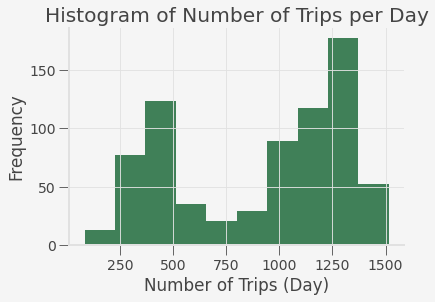

In [843]:
# Histogram of number of trips grouped by day
fig, ax = plt.subplots()

trip_weather.plot(kind="hist", y="num_trip", 
                  color="#408058",
                  legend=False, ax=ax)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Histogram of Number of Trips per Day")
ax.set_xlabel("Number of Trips (Day)")

Based on the above histogram, the bike share has been used approximately 1300 times daily for 175 days. The values are in the range from about 100 to somewhere around 1500. 

Text(0.5, 0, 'Average Temperature (°F)')

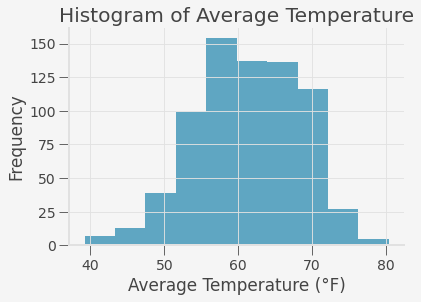

In [844]:
fig, ax = plt.subplots()

trip_weather.plot(kind="hist", y="mean_temperature_f",
                  color="#5fa6c2",
                  legend=False, ax=ax)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Histogram of Average Temperature")
ax.set_xlabel("Average Temperature (°F)")

The distribution of average temperature is unimodal and approximately symmetric, with the highest frequency occurring around 55°F.  

Text(0, 0.5, 'Count')

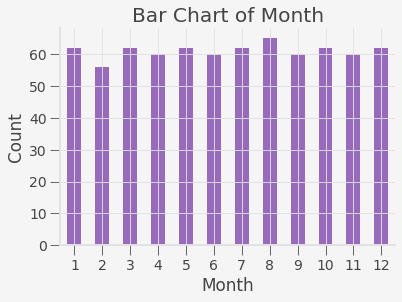

In [845]:
gbm = trip_weather.groupby("month").count()
gbm = gbm.reset_index()

fig, ax = plt.subplots()

gbm.plot.bar(x="month", y="num_trip",
             color="#976abd", legend=False, 
             ax=ax, rot=0)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Bar Chart of Month")
ax.set_xlabel("Month")
ax.set_ylabel("Count")

# plt.bar(gbm["month"], gbm["num_trip"])
# plt.title("Bar Chart of Month")
# plt.xlabel("Month")
# plt.ylabel("Frequency")

As we can see in the above bar chart, the frequency of each month is roughly the same. Some months have less value for count, and this may be due to the absence of data for some specific days.

Text(0, 0.5, 'Number of Trips')

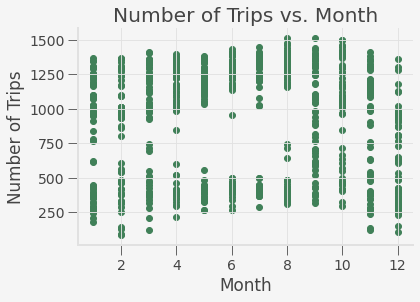

In [846]:
fig, ax = plt.subplots()

ax.scatter(x=trip_weather["month"], 
           y=trip_weather["num_trip"], 
           color="#408058")
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Number of Trips vs. Month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Trips")

There is no clear relationship between the number of trips and the twelve months. Rentals of bikes were on average more likely from August to October than from November to February.

Text(0, 0.5, 'Number of Trips')

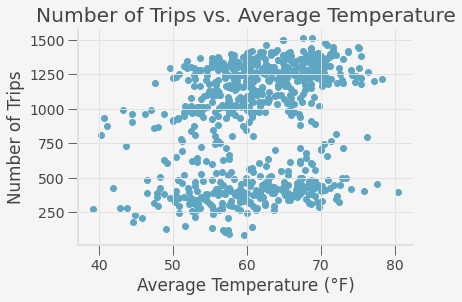

In [847]:
fig, ax = plt.subplots()

ax.scatter(x=trip_weather["mean_temperature_f"], 
           y=trip_weather["num_trip"],
           color="#5fa6c2")
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Number of Trips vs. Average Temperature")
ax.set_xlabel("Average Temperature (°F)")
ax.set_ylabel("Number of Trips")

The scatterplot of the number of trips versus average temperature shows two clusters each exhibits a linear trend. This implies that there may be some confounding variables causing a significant difference between the number of daily trips of the two groups. In general, people prefer bike trips on days with moderate or warmer weather over days with cold weather.

### Histogram of Number of Trips per Day from 2013-2015

In [848]:
# Creating a new variable to record whether the observation is on weekday/weekend
for row in trip_weather.iterrows():
    index_value, column_values = row
    clean_number = column_values["start_date_normalize"].weekday()
    if clean_number < 5:
        trip_weather.at[index_value, "week"] = "weekday"
    else:
        trip_weather.at[index_value, "week"] = "weekend"

# Creating a new variable to record the year of the observation
for row in trip_weather.iterrows():
    index_value, column_values = row
    clean_number = column_values["start_date_normalize"].year
    trip_weather.at[index_value, "year"] = clean_number
    
trip_weather["year"] = trip_weather.year.astype(int)

Text(0.5, 0.98, 'Histogram of Number of Trips per Day')

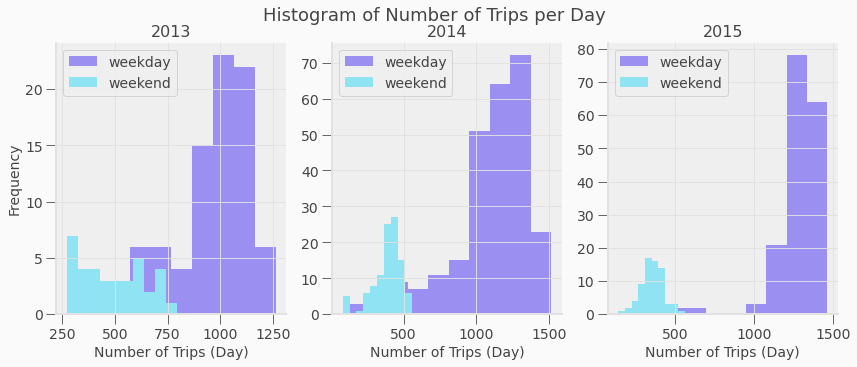

In [849]:
def single_hist(df, year, week, ax, color):
    # Filter data to keep only the data of interest
    _df = df.query("(year == @year) & (week == @week)")
    _df.plot(
        kind="hist", y="num_trip", label=week, ax=ax, color=color
    )

    return ax

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
colors = {"weekday": "#9c8ff2", "weekend": "#8fe3f2"}

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, year) in enumerate(trip_weather.year.unique()):
    single_hist(trip_weather, year, "weekday", ax[i], colors["weekday"])
    single_hist(trip_weather, year, "weekend", ax[i], colors["weekend"])
    ax[i].set_title(str(year), fontsize=16)
    ax[i].set_xlabel("Number of Trips (Day)", fontsize=14)

for (i, _ax) in enumerate(ax):
    if i == 0:
        _ax.set_ylabel("Frequency", fontsize=14)
    else:
        _ax.set_ylabel("")
        
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

fig.suptitle("Histogram of Number of Trips per Day", fontsize=18)

People travel much more on weekdays than on weekends, observing from the histogram above. Especially in 2015, there was a significant difference in the number of trips per day between the two groups. In addition, bike share usage increased gradually from 2013 to 2015. Observations indicate weekday is in purple and weekend is in blue.

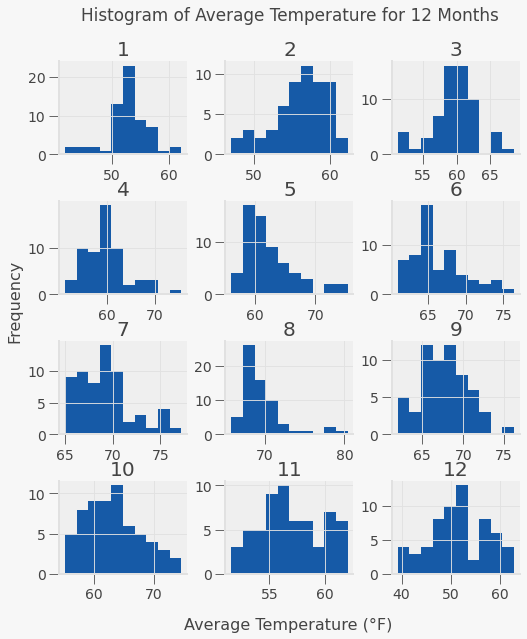

In [850]:
trip_weather["mean_temperature_f"].hist(by=trip_weather["month"],
                                        figsize=(8, 9.5), rot=0)
plt.suptitle("Histogram of Average Temperature for 12 Months")
plt.text(17, -8, "Average Temperature (°F)", ha='center', fontsize=16)
plt.text(-40, 40, "Frequency", va='center', rotation='vertical', fontsize=16)
plt.show()

The twelve histograms each indicates the distribution of average temperature during specific month of the year. We observe that from June to September the mean of average temperature is high. While from December to February the temperature is relatively low to other months. This is consistent with previous plots, in which months with higher temperature is related to frequent bike rentals.

# Project Two

## THE MESSAGE

The daily usage of bike share varies significantly between weekdays and weekends, while people tend to go out more in warm weather months than when the weather is bad.

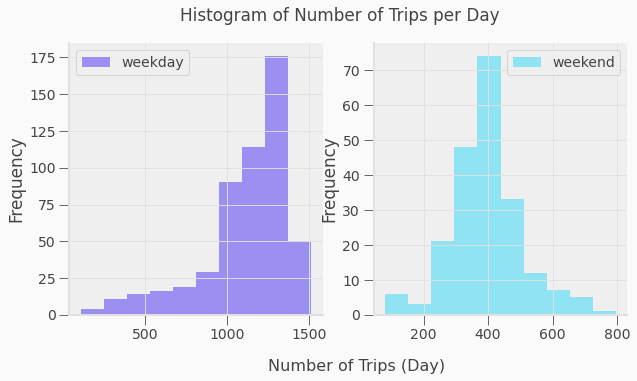

In [851]:
def single_hist(df, week, ax, color):
    # Filter data to keep only the data of interest
    _df = df.query("(week == @week)")
    _df.plot(
        kind="hist", y="num_trip", label=week, ax=ax, color=color
    )

    return ax

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = {"weekday": "#9c8ff2", "weekend": "#8fe3f2"}

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
single_hist(trip_weather, "weekday", ax[0], colors["weekday"])
single_hist(trip_weather, "weekend", ax[1], colors["weekend"])

plt.suptitle("Histogram of Number of Trips per Day")
plt.text(-9, -16, "Number of Trips (Day)", ha='center', fontsize=16)

# ax.set_title("Histogram of Number of Trips per Day", fontsize=18)
# ax.set_xlabel("Number of Trips (Day)", fontsize=14)

        
_ax.spines['right'].set_visible(False)
_ax.spines['top'].set_visible(False)
    

Text(0, 0.5, 'Number of Trips')

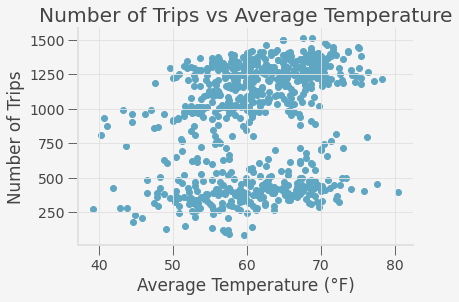

In [852]:
fig, ax = plt.subplots()

ax.scatter(x=trip_weather["mean_temperature_f"], 
           y=trip_weather["num_trip"],
           color="#5fa6c2")
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Number of Trips vs Average Temperature")
ax.set_xlabel("Average Temperature (°F)")
ax.set_ylabel("Number of Trips")

## Maps

### Average number of trips (2013 & 2015)

Considering that the weather dataset does not distinguish temperatures between places and the month is a categorical variable, the two maps in this section will display the dependent variable, the average number of trips per day for years 2013 and 2015.

In [853]:
trip = pd.read_csv("/Users/rachelchen/Desktop/UofT/\
ECO225/ECO225Project/Data/archive/trip.csv")
trip["start_date_normalize"] = pd.to_datetime(trip["start_date"]
                                             ).dt.normalize()

# Remove 6619 observations missing value in zip code
trip["zip_code"].isnull().sum()
trip = trip.dropna(subset=["zip_code"])

# Create a variable for years
for row in trip.iterrows():
    index_value, column_values = row
    clean_number = column_values["start_date_normalize"].year
    trip.at[index_value, "year"] = clean_number
    
trip["year"] = trip.year.astype(int)

# Filter data to only having five digits for the zip code
trip = trip[trip['zip_code'].apply(len) == 5]

In [854]:
# Using groupby to count daily trips
gzc_count = trip.groupby(["zip_code", "year", "start_date_normalize"]).count()
gzc_count["num_trip"] = gzc_count["start_date"]
gzc_count = gzc_count.reset_index()
gzc_count

gzc_mean = gzc_count[["zip_code", "year", "num_trip"]].groupby(["zip_code", "year"]).mean()
gzc_mean = gzc_mean.reset_index()

In [855]:
# Read the zip code shapefile for San Francisco Bay Area
gpd_zc = gpd.read_file("file:///Users/rachelchen/Desktop/\
UofT/ECO225/ECO225Project/Data/Bay%20Area%20ZIP%20Codes.zip")

In [856]:
# Merge the mean trip dataset gzc_mean created in the previous step 
# to the San Francisco Bay Area shapefile by the zip code.
gpd_zc_trip = pd.merge(gzc_mean, gpd_zc, left_on = "zip_code", right_on = "zip", how = "left")
gpd_zc_trip = gpd_zc_trip[["zip_code", "year", "num_trip", "geometry"]]
gpd_zc_trip = gpd_zc_trip[gpd_zc_trip["geometry"] != None]
gpd_zc_trip = gpd_zc_trip.rename(columns={"num_trip": "mean_trip"})

In [857]:
# 2013 & 2015 GeoDataFrame
SFBA13 = gpd_zc_trip[gpd_zc_trip["year"] == 2013]
SFBA15 = gpd_zc_trip[gpd_zc_trip["year"] == 2015]

SFBA13 = gpd.GeoDataFrame(SFBA13, geometry="geometry")
SFBA15 = gpd.GeoDataFrame(SFBA15, geometry="geometry")

For the purpose of comparing the average with years 2013 and 2015, two separate GeoDataFrames are created.  

In [858]:
# Data of observations with mean trip above 20
greater20_13 = SFBA13[SFBA13['mean_trip'] > 20] # 
greater20_15 = SFBA15[SFBA15['mean_trip'] > 20]

# Maximum 'mean_trip' observations
greater20_13[greater20_13["mean_trip"]==max(greater20_13["mean_trip"])]
greater20_15[greater20_15["mean_trip"]==max(greater20_15["mean_trip"])]

# Filtered data 
summary_13 = SFBA13[SFBA13['mean_trip'] <= 20]["mean_trip"].describe()
summary_15 = SFBA15[SFBA15['mean_trip'] <= 20]["mean_trip"].describe()

# Maximum & minimum observations in the data 
max_13 = SFBA13[SFBA13["mean_trip"]==18.098360655737704]
min_13 = SFBA13[SFBA13["mean_trip"]==1]

max_15 = SFBA15[SFBA15["mean_trip"]==18.466667]
min_15 = SFBA15[SFBA15["mean_trip"]==1]

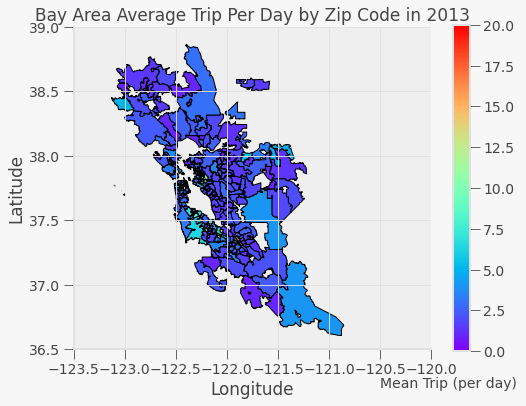

In [859]:
fig, gax = plt.subplots(figsize = (8,6))

# Plot the zip codes with 'mean_trip' <= 20 as the value for color
SFBA13.plot(ax=gax, edgecolor='black', column='mean_trip', legend=True, cmap='rainbow', vmin=0, vmax=20) 
gax.annotate('Mean Trip (per day)', xy=(0.66, 0.042),  xycoords='figure fraction')

gax.set_title("Bay Area Average Trip Per Day by Zip Code in 2013", fontsize=17)
gax.set_xlabel("Longitude")
gax.set_ylabel("Latitude")

plt.xlim((-123.5, -120))
plt.ylim((36.5, 39))
plt.show()

The heat maps display the average number of trips per day grouped by zip code in the San Francisco Bay Area in 2013. Seven observations with mean trips per day higher than 20 are excluded for us to focus on the more common values. Most bike-share usage is in the small bright red portion of the map, which has a value of 18.1 and a zip code of 94117, located in San Francisco. In contrast, dark purple areas depict the least amount of bike rentals. In this case, the minimum value is 1. A total of 18 zip codes have a value of 1, including 94037, located in Montara. This map is created using the Bay Area zip codes data downloaded from San Francisco Open Data website. Even if we exclude the average trip above 20, the map still appears blue or purple. Among all zip codes, the mean daily trip in 2013 was less than 5. Large areas tend to contain fewer records, while the location shown in red is smaller but has an average of around 20 bike share usage. The highest observation from the excluded rows is 88.3, with a zip code of 94107, located in San Francisco.

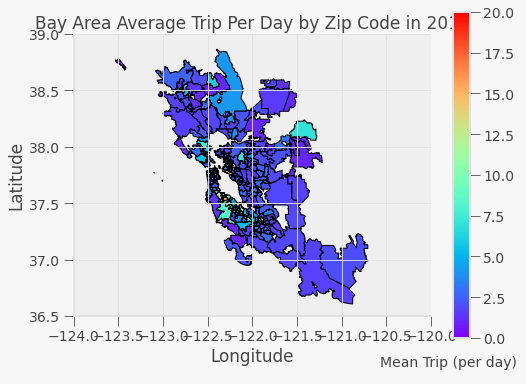

In [860]:
fig, gax = plt.subplots(figsize = (8,6))

# Plot the zip codes with 'mean_trip' <= 20 as the value for color
SFBA15.plot(ax=gax, edgecolor='black', column='mean_trip', legend=True, cmap='rainbow', vmin=0, vmax=20) 
gax.annotate('Mean Trip (per day)', xy=(0.66, 0.042),  xycoords='figure fraction')

gax.set_title("Bay Area Average Trip Per Day by Zip Code in 2015", fontsize=17)
gax.set_xlabel("Longitude")
gax.set_ylabel("Latitude")

plt.xlim((-124, -120))
plt.ylim((36.5, 39))
plt.show()

On the Bay Area map for 2015, the average bike trip per day appears more purple in areas with fewer bike rental activities in 2013. A slight increase in bike share usage occurred in areas with mean trips over five per day in 2013. A limit of 20 excludes six observations having an average bike trip per day higher than 20, and the highest observation is also in San Francisco with zip code 94107, which has a mean of 130.1.

# Project 3

## THE MESSAGE

Petrolum prices may be one of the factors that influences our response variable, bike share usage per day. Since vehicle usage is tightly related to the price of oil, as price goes up it is costly to drive a car. Instead of driving the car they will choose other means of transportation such as buses, subways, or bicycles. This generates increase of bike rental activities. Hence, including the monthly data for gasoline prices by month help to explain the variation in the use of bike share. The data comes from U.S. Energy Information Administration website (https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_sca_dpg&f=m). Since the data is recorded by month and year, I merged it to my previous dataset according to year and month. Then we visualize the variation in oil prices to daily bike rentals grouped by month using scatterplots or histograms.

There is no need to run the program every day since my dataset only includes data in the past, from 2013 to 2015. Since these years' monthly gasoline prices were already recorded and are fixed. The data for oil prices can be scraped from the U.S. Energy Information Administration website, which it provides official energy information and are open to the public. 

## Web-Scraping (HTML-Based)

The data for gasoline prices in California includes 23 years from June 2000 up to February 2022.

In [861]:
import requests
import urllib.request
from bs4 import BeautifulSoup

web_url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_sca_dpg&f=m'
response = requests.get(web_url)
soup_object = BeautifulSoup(response.content)
data_table = soup_object.find_all('table', 'FloatTitle')[0]
all_values = data_table.find_all('tr')

ca_gas = pd.DataFrame(columns = ['Year', 'Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 

ix = 0
for row in all_values[1:]:
    values = row.find_all('td') 
    if len(values) == 13:
        Year = values[0].text
        Jan = values[1].text
        Feb = values[2].text
        Mar = values[3].text
        Apr = values[4].text
        May = values[5].text
        Jun = values[6].text
        Jul = values[7].text
        Aug = values[8].text
        Sep = values[9].text
        Oct = values[10].text
        Nov = values[11].text
        Dec = values[12].text

        ca_gas.loc[ix] = [Year, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec] 
        ix += 1

ca_gas.to_csv('ca_gas.csv', index=False)
ca_gas['Year'] = ca_gas['Year'].astype(int)

### Explanation of steps for web-scaping

First import packages requests, urllib.request, and BeautifulSoup which have functions that we apply afterwards. Create a variable to store the link that includes the data for oil prices in California. Set a variable named response for us to connect to information from the url, and then parse and store the content from this url to a soup object. Right click in the website and go to inspect to search for where the tag equals table, and copy the class name 'FloatTitle', as the second parameter to the function find_all(). There is only one table on the website, so the index is zero. "tr" means the table row, in this case we want to extract all the rows from the table. Then store the data to all_values. 

Next we create a new empty dataframe called ca_gas, and only store the column names. "ix" is a constant that helps to count for which row we are extracting the data from, indexed starting from zero. Iterate through all rows in the table, one at each time. Adding values for each column to the dataframe ca_gas, but only when a row includes observation for year and months. Since there are four empty lines that runs an error if we scrape it. The index now is one unit higher as we move on to iterate another row. After the dataframe includes all the observations, we need to store it to csv file, I named it ca_gas.csv.

### Scraped Dataset

In [862]:
ca_gas = ca_gas[(ca_gas['Year'] == 2013)|(ca_gas['Year'] == 2014)|(ca_gas['Year'] == 2015)]
ca_gas = ca_gas.reset_index()
ca_gas = ca_gas.drop(columns=["index"])
ca_gas

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2013,3.678,4.127,4.192,4.031,4.051,4.050,4.056,3.919,3.989,3.829,3.641,3.642
1,2014,3.666,3.726,3.984,4.210,4.220,4.163,4.110,3.961,3.821,3.585,3.234,2.916
2,2015,2.596,2.756,3.388,3.261,3.804,3.596,3.812,3.594,3.175,2.945,2.819,2.776


**Here is the dataset of oil prices for the years 2013, 2014, and 2015 which matches the range of years in our dataset by filtering the table we scraped from the web. The columns of this dataset are in month, from January to December with year.**

There are some adjustment of the format of the dataframe, we want year, month, and oil price as the column variables.

In [863]:
# Separate the data into three dataframes for the record of each year's oil prices
tca_gas_2013 = ca_gas[ca_gas["Year"]==2013].T[1:]
tca_gas_2014 = ca_gas[ca_gas["Year"]==2014].T[1:]
tca_gas_2015 = ca_gas[ca_gas["Year"]==2015].T[1:]

# Create lists for years
yr13 = []
yr13.extend([2013]*12)
yr14 = []
yr14.extend([2014]*12)
yr15 = []
yr15.extend([2015]*12)

# Create a list for months in integer
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12]

# Combine the lists and data for oil prices to 'year', 'month', 
# and 'oil price' columns to form a new dataframe
oil_pr = pd.DataFrame({"year": yr13 + yr14 + yr15,
                       "month": list(range(1, 13)) * 3, 
                       "oil price": list(tca_gas_2013[0]) + list(tca_gas_2014[1]) + list(tca_gas_2015[2])
})

oil_pr["oil price"] = oil_pr["oil price"].astype(float)

### Merging the new data to original data

In [864]:
# Merge oil prices dataset 'oil_pr' to the original dataset 
# 'trip_weather' by year and month
trip_op = pd.merge(trip_weather, oil_pr, left_on = ["year", "month"], right_on = ["year", "month"], how = "left")
trip_op.head()

,start_date_normalize,num_trip,mean_temperature_f,month,week,year,oil price
0,2013-08-29,748,70.4,8,weekday,2013,3.919
1,2013-08-30,714,73.0,8,weekday,2013,3.919
2,2013-08-31,640,68.0,8,weekend,2013,3.919
3,2013-09-01,706,70.0,9,weekend,2013,3.989
4,2013-09-02,661,70.8,9,weekday,2013,3.989


Here is the first five rows of the new dataset after merging oil prices data with our original data. A new column for
oil price is added.

## Visualizations of Oil Price

### Line Chart of Monthly Oil Prices from 2013 to 2015

In [865]:
tca_gas_2013 = tca_gas_2013.reset_index()
tca_gas_2014 = tca_gas_2014.reset_index()
tca_gas_2015 = tca_gas_2015.reset_index()

tca_gas_2013 = tca_gas_2013.rename(columns={"index":"month", 0: "2013"})
tca_gas_2014 = tca_gas_2014.rename(columns={"index":"month", 1: "2014"})
tca_gas_2015 = tca_gas_2015.rename(columns={"index":"month", 2: "2015"})

tca_gas_2013["2013"] = tca_gas_2013["2013"].astype(float)
tca_gas_2014["2014"] = tca_gas_2014["2014"].astype(float)
tca_gas_2015["2015"] = tca_gas_2015["2015"].astype(float)

Text(0.5, 0.98, 'Monthly Oil Price(2013-2015)')

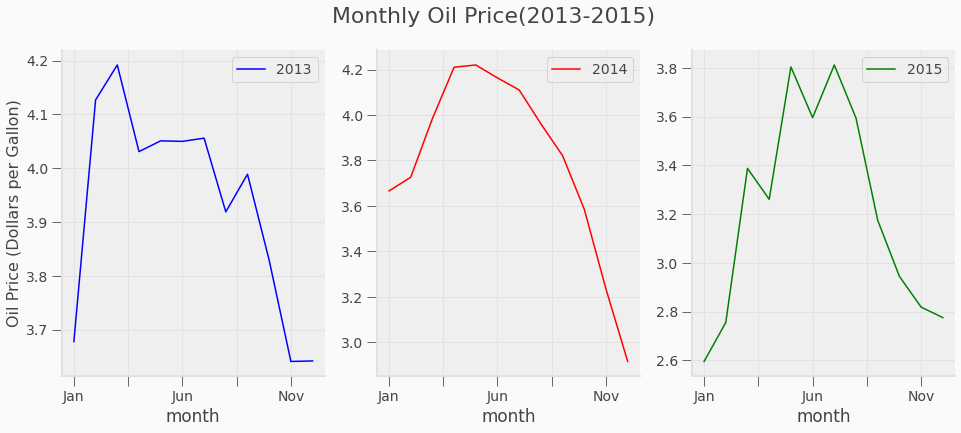

In [866]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)

tca_gas_2013.plot(kind="line", y="2013", x="month", ax=ax[0], color="b")
tca_gas_2014.plot(kind="line", y="2014", x="month", ax=ax[1], color="r")
tca_gas_2015.plot(kind="line", y="2015", x="month", ax=ax[2], color="g")

for (i, _ax) in enumerate(ax):
    if i == 0:
        _ax.set_ylabel("Oil Price (Dollars per Gallon)", fontsize=16)
    else:
        _ax.set_ylabel("")
        
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    
fig.suptitle("Monthly Oil Price(2013-2015)", fontsize=22)

All tree years' line chart shows that oil price increases from Janurary and then decreases around the middle of the year to December. On average oil prices in 2015 was lower than 2013 and 2014, having a maximum of \$3.8 per Gallon and a minimum of \$2.6 Gallon.

### Scatterplot of Oil Price and the Dependent Variable

Text(0.5, 0.98, 'Number of Trips per Day vs Monthly Oil Price (2013-2015)')

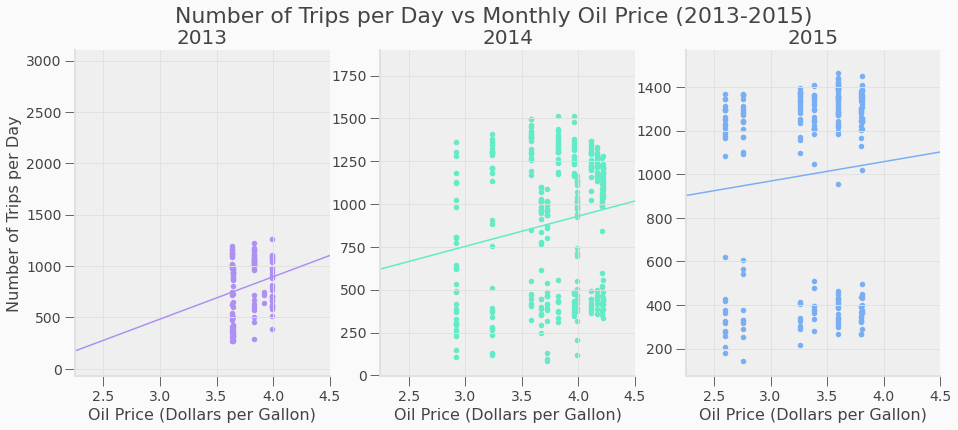

In [867]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 3, figsize=(15.5, 6))

def single_scatter(df, year, ax, color):
    # Filter data to keep only the data of interest
    _df = df.query("(year == @year)")
    _df.plot(
        kind="scatter", y="num_trip", x="oil price", ax=ax, color=color
    )
    
    lr = LinearRegression()
    X = _df["oil price"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
    y = _df["num_trip"].values.reshape(-1, 1) # the output is an array
    lr.fit(X, y)

    x = np.linspace(2.0, 9.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred, color=color)

    return ax

colors = {"2013": "#AD90F2", "2014": "#62EBC6", "2015": "#78AEF3"}

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)

for (i, year) in enumerate(trip_op.year.unique()):
    single_scatter(trip_op, year, ax[i], colors[str(year)])
    
    ax[i].set_title(str(year), fontsize=20)
    ax[i].set_xlabel("Oil Price (Dollars per Gallon)", fontsize=16)
    ax[i].set_xlim(2.25, 4.5)

for (i, _ax) in enumerate(ax):
    if i == 0:
        _ax.set_ylabel("Number of Trips per Day", fontsize=16)
    else:
        _ax.set_ylabel("")
        
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    
fig.suptitle("Number of Trips per Day vs Monthly Oil Price (2013-2015)", fontsize=22)

The three scatterplots exhibit relationship between trips per day and oil prices by month from 2013 to 2015. In 2013, the oil prices were high for each month on average, ranging from 3.60 to 4.00 U.S. dollars per gallon. In contrast, in 2014, oil prices were in a broader range from about \$2.75 to \$4.25. Observations of bike share usage clustered when the oil price was around \$4.00, and in 2015 the cost for some months reached below \$3.00. Thus on average, oil prices were lower compared to other years. The effect of oil price was reflected in a flatter slope of the regression line, indicating that the oil price fewer influences bike share use.

# Final Project

Analyzing previous visualizations, we see a positive linear relationship between the temperature and the frequency of bike trips in the San Francisco Bay Area. This is reasonable since the average temperature ranges from 40 (4.44°C) to 80 (26.67°C) Fahrenheit. The warmer weather encourages people for outdor activities, usually in the summer when there are more vacations. In contrast, the scatterplot depicting the trip versus month showed a non-linear pattern, similar to a hump-shaped curve. The usage of bike share increases from January to September, then decreases. It seems that the bump matches the months during the summer, so there are some correlations between the month and the average temperature.

## Regression Models

Below are the four regression equations. All are multiple regressions with the weekday indicator variable unchanged since it is the subgroup we previously observed. The weekend traveler subgroup was far higher than the weekday traveler subgroup. The first model is a basic linear model including temperature and weekday as predictors. From our trip versus month scatterplot, we discovered that they are non-linearly related. Since month is a categorical variable, eleven indicators for month from Janurary to November are added to the second model. with December as the omitted category. The third model shows a combination of the two core predictor variables, temperature and month. We want to compare this model with the first two, to see whether month and temperature are better at explaining the response together. The last model is used to determine whether the average number of trips per day differs from year to year. In this case two extra indicators for years 2014 and 2015 were added, with 2013 as the omitted category. 

$$
{Num\_trip}_i = \beta_0 + \beta_1{Temp}_i + \beta_2{Weekday}_i + \epsilon_i
$$

$$
{Num\_trip}_i = \beta_0 + \beta_1{Jan}_i + \beta_2{Feb}_i + \beta_3{Mar}_i + \beta_4{Apr}_i + \beta_5{May}_i + \beta_6{Jun}_i + \beta_6{Jun}_i + \beta_7{Jul}_i + \beta_8{Aug}_i + \beta_9{Sep}_i + \beta_{10}{Oct}_i + \beta_{11}{Nov}_i + \beta_{12}{Temp}_i + \beta_{13}{Weekday}_i + \epsilon_i
$$

$$
{Num\_trip}_i = \beta_0 + \beta_1{Jan}_i + \beta_2{Feb}_i + \beta_3{Mar}_i + \beta_4{Apr}_i + \beta_5{May}_i + \beta_6{Jun}_i + \beta_6{Jun}_i + \beta_7{Jul}_i + \beta_8{Aug}_i + \beta_9{Sep}_i + \beta_{10}{Oct}_i + \beta_{11}{Nov}_i + \beta_{12}{Temp}_i + \beta_{14}{Year14}_i + \beta_{15}{Year15}_i + \beta_{16}{Weekday}_i + \epsilon_i
$$

$$
{Num\_trip}_i = \beta_0 + \beta_1{Jan}_i + \beta_2{Feb}_i + \beta_3{Mar}_i + \beta_4{Apr}_i + \beta_5{May}_i + \beta_6{Jun}_i + \beta_6{Jun}_i + \beta_7{Jul}_i + \beta_8{Aug}_i + \beta_9{Sep}_i + \beta_{10}{Oct}_i + \beta_{11}{Nov}_i + \beta_{12}{Temp}_i  + \beta_{13}{Year14}_i + \beta_{14}{Year15}_i + \beta_{15}{OP}_i + \beta_{16}{Weekday}_i + \epsilon_i
$$

### Variables

***Num_trip:*** Number of trips per day  
***Temp:*** Temperature measuered in Fahrenheit  
***OP:*** Oil price in dollars per Gallon  
***Weekday:*** A dummy variable equals to 1 if the observation is on weekday and 0 on weekend.   
***Jan-Dec:*** Abbreviations for months  
***Year14:*** Equals 1 if Observations in 2014 and 0 otherwise.  
***Year15:*** Equals 1 if observations in 2015 and 0 otherwise.  
$\mathbf{\epsilon_i}$: The residual or error term for the $i^{th}$ observation, equals to the difference between the actual and predicted response.  

**In order to fit the multiple regression models, we have to create 14 more variables, indicator variables from Janurary to November, weekday, year 2014, and year 2015.**

In [868]:
# Create indicator variables for year 2014 and 2015, the omitted category is 2013.
trip_weather.loc[trip_weather["year"] == 2014, "year14"] = 1
trip_weather.loc[trip_weather["year"] != 2014, "year14"] = 0

trip_weather.loc[trip_weather["year"] == 2015, "year15"] = 1
trip_weather.loc[trip_weather["year"] != 2015, "year15"] = 0

# Create a dummy variable for weekday observaions (1-weekday, 0-weekend)
trip_weather.loc[trip_weather["week"] == "weekday", "weekday"] = 1
trip_weather.loc[trip_weather["week"] == "weekend", "weekday"] = 0

# Merge the oil price dataset to trip_weather
trip_weather = pd.merge(trip_weather, oil_pr, left_on = ["year", "month"], 
                        right_on = ["year", "month"], how = "left")

In [869]:
# Adding 11 month dummies to the dataset
for i in range(1,13):
    if i == 1:
        trip_weather.loc[trip_weather["month"] == 1, "Jan"] = 1
        trip_weather.loc[trip_weather["month"] != 1, "Jan"] = 0
    elif i == 2:
        trip_weather.loc[trip_weather["month"] == 2, "Feb"] = 1
        trip_weather.loc[trip_weather["month"] != 2, "Feb"] = 0
    elif i == 3:
        trip_weather.loc[trip_weather["month"] == 3, "Mar"] = 1
        trip_weather.loc[trip_weather["month"] != 3, "Mar"] = 0
    elif i == 4:
        trip_weather.loc[trip_weather["month"] == 4, "Apr"] = 1
        trip_weather.loc[trip_weather["month"] != 4, "Apr"] = 0
    elif i == 5:
        trip_weather.loc[trip_weather["month"] == 5, "May"] = 1
        trip_weather.loc[trip_weather["month"] != 5, "May"] = 0
    elif i == 6:
        trip_weather.loc[trip_weather["month"] == 6, "Jun"] = 1
        trip_weather.loc[trip_weather["month"] != 6, "Jun"] = 0
    elif i == 7:
        trip_weather.loc[trip_weather["month"] == 7, "Jul"] = 1
        trip_weather.loc[trip_weather["month"] != 7, "Jul"] = 0
    elif i == 8:
        trip_weather.loc[trip_weather["month"] == 8, "Aug"] = 1
        trip_weather.loc[trip_weather["month"] != 8, "Aug"] = 0
    elif i == 9:
        trip_weather.loc[trip_weather["month"] == 9, "Sep"] = 1
        trip_weather.loc[trip_weather["month"] != 9, "Sep"] = 0
    elif i == 10:
        trip_weather.loc[trip_weather["month"] == 10, "Oct"] = 1
        trip_weather.loc[trip_weather["month"] != 10, "Oct"] = 0
    elif i == 11:
        trip_weather.loc[trip_weather["month"] == 11, "Nov"] = 1
        trip_weather.loc[trip_weather["month"] != 11, "Nov"] = 0

In [870]:
# Add constant term to trip_weather dataset
trip_weather['const'] = 1

# Lists of x-variables for each regression
X1 = ['const', 'mean_temperature_f', 'weekday']
X2 = ['const', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
      'Oct', 'Nov', 'mean_temperature_f', 'weekday']
X3 = ['const', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
      'Oct', 'Nov', 'mean_temperature_f', 'year14', 'year15', 'weekday']
X4 = ['const', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
      'Oct', 'Nov', 'mean_temperature_f', 'year14', 'year15', 'oil price', 'weekday']
# X5 = ['const', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
#       'Oct', 'Nov', 'mean_temperature_f', 'weekday', 'year14', 'year15']

# OLS regressions
reg1 = sm.OLS(trip_weather['num_trip'], trip_weather[X1], missing='drop').fit()
reg2 = sm.OLS(trip_weather['num_trip'], trip_weather[X2], missing='drop').fit()
reg3 = sm.OLS(trip_weather['num_trip'], trip_weather[X3], missing='drop').fit()
reg4 = sm.OLS(trip_weather['num_trip'], trip_weather[X4], missing='drop').fit()

In [906]:
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:               num_trip   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     969.0
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          3.56e-206
Time:                        16:44:25   Log-Likelihood:                -4961.6
No. Observations:                 733   AIC:                             9929.
Df Residuals:                     730   BIC:                             9943.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -474.6233     69

## Result

In [871]:
from statsmodels.iolib.summary2 import summary_col
# Create a dictionary for F-statistic, AIC, BIC, and number of observations
info_dict={'F-statistic' : lambda x: f"{x.fvalue:.2f}",
           'AIC' : lambda x: f"{x.aic:.2f}",
           'BIC' : lambda x: f"{x.bic:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

In [872]:
# The regression table
results_table = summary_col(results=[reg1,reg2,reg3,reg4],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'mean_temperature_f',
                                             'Jan',
                                             'Feb',
                                             'Mar',
                                             'Apr',
                                             'May',
                                             'Jun',
                                             'Jul',
                                             'Aug',
                                             'Sep',
                                             'Oct',
                                             'Nov',
                                             'year14',
                                             'year15',
                                             'oil pice',
                                             'weekday'])

results_table.add_title('OLS Regressions')

print(results_table)

                       OLS Regressions
                    Model 1    Model 2    Model 3    Model 4 
-------------------------------------------------------------
const              -474.62*** -342.26*** -317.07*** -201.68  
                   (69.30)    (105.77)   (103.27)   (223.52) 
mean_temperature_f 14.20***   8.79***    7.55***    7.42***  
                   (1.11)     (1.98)     (1.98)     (2.00)   
Jan                           194.41***  97.58**    108.71** 
                              (36.69)    (38.44)    (42.94)  
Feb                           141.67***  48.96      63.98    
                              (38.63)    (39.71)    (47.37)  
Mar                           220.81***  132.54***  162.05** 
                              (39.96)    (40.54)    (64.91)  
Apr                           243.21***  155.19***  186.28***
                              (40.39)    (40.91)    (67.28)  
May                           227.96***  142.83***  182.93** 
                              (

According to the table above, including four regression models, each has a different set of predictors. Hence, we need to compare them using the adjusted R-squared. Their adjusted R-squared is around 0.75, so the model explains the response well. For example, the first model has a 73% variation in bike trips per day explained by temperature and weekday/weekend. Model 1 has the largest F-statistic of 969.03, which indicates that this model is highly statistically significant overall. All four models have AIC and BIC above 9000, almost 10,000. Lower AIC and BIC suggest that it is preferable to the other three models. With variables oil price added to the fourth model, BIC does penalize the model. Therefore, model 3 is preferable among the four since it has a higher adjusted R-squared, a large enough F-statistic, smallest AIC and BIC. Most of the slope coefficients are statistically significant at a 1% significance level. In February, the count for bike trips does not statistically differ from December if holding temperature, year, weekday, and oil price fixed. On the other hand, after controlling temperature, month, year, and weekday, the oil price is not statistically significant in explaining the response.

Days with one Fahrenheit higher temperature have daily bike trips on average eight more, controlling for the month, year, and week of the day. Summer months like June have the highest number of bike trips per day, an average of 190 more than in December. All positive coefficients indicate that December is the least common month for a bike trip, after controlling whether travellers use the bike share on weekdays or weekends, year, and temperature. After fixing the year, month, and temperature, weekday bike share usage was approximately 726 per day, more on average than on the weekend. As we observed from the summary statistic table, the maximum number of trips per day is 1516. Thus, this slope coefficient is highly statistically significant and highly economically significant. The year also contributes to explaining the response. The bike-share system becomes more popular with each passing year, holding temperature, month, and weekday fixed.

## Regression Tree

In [903]:
trip_weather

,start_date_normalize,num_trip,mean temperature (°F),month,week,year,year14,year15,weekday,oil price,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,const
0,2013-08-29,748,70.4,8,weekday,2013,0.0,0.0,1.0,3.919,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,2013-08-30,714,73.0,8,weekday,2013,0.0,0.0,1.0,3.919,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,2013-08-31,640,68.0,8,weekend,2013,0.0,0.0,0.0,3.919,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,2013-09-01,706,70.0,9,weekend,2013,0.0,0.0,0.0,3.989,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,2013-09-02,661,70.8,9,weekday,2013,0.0,0.0,1.0,3.989,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,2015-08-27,1443,75.2,8,weekday,2015,0.0,1.0,1.0,3.594,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
729,2015-08-28,1220,78.2,8,weekday,2015,0.0,1.0,1.0,3.594,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
730,2015-08-29,342,72.0,8,weekend,2015,0.0,1.0,0.0,3.594,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
731,2015-08-30,331,70.2,8,weekend,2015,0.0,1.0,0.0,3.594,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


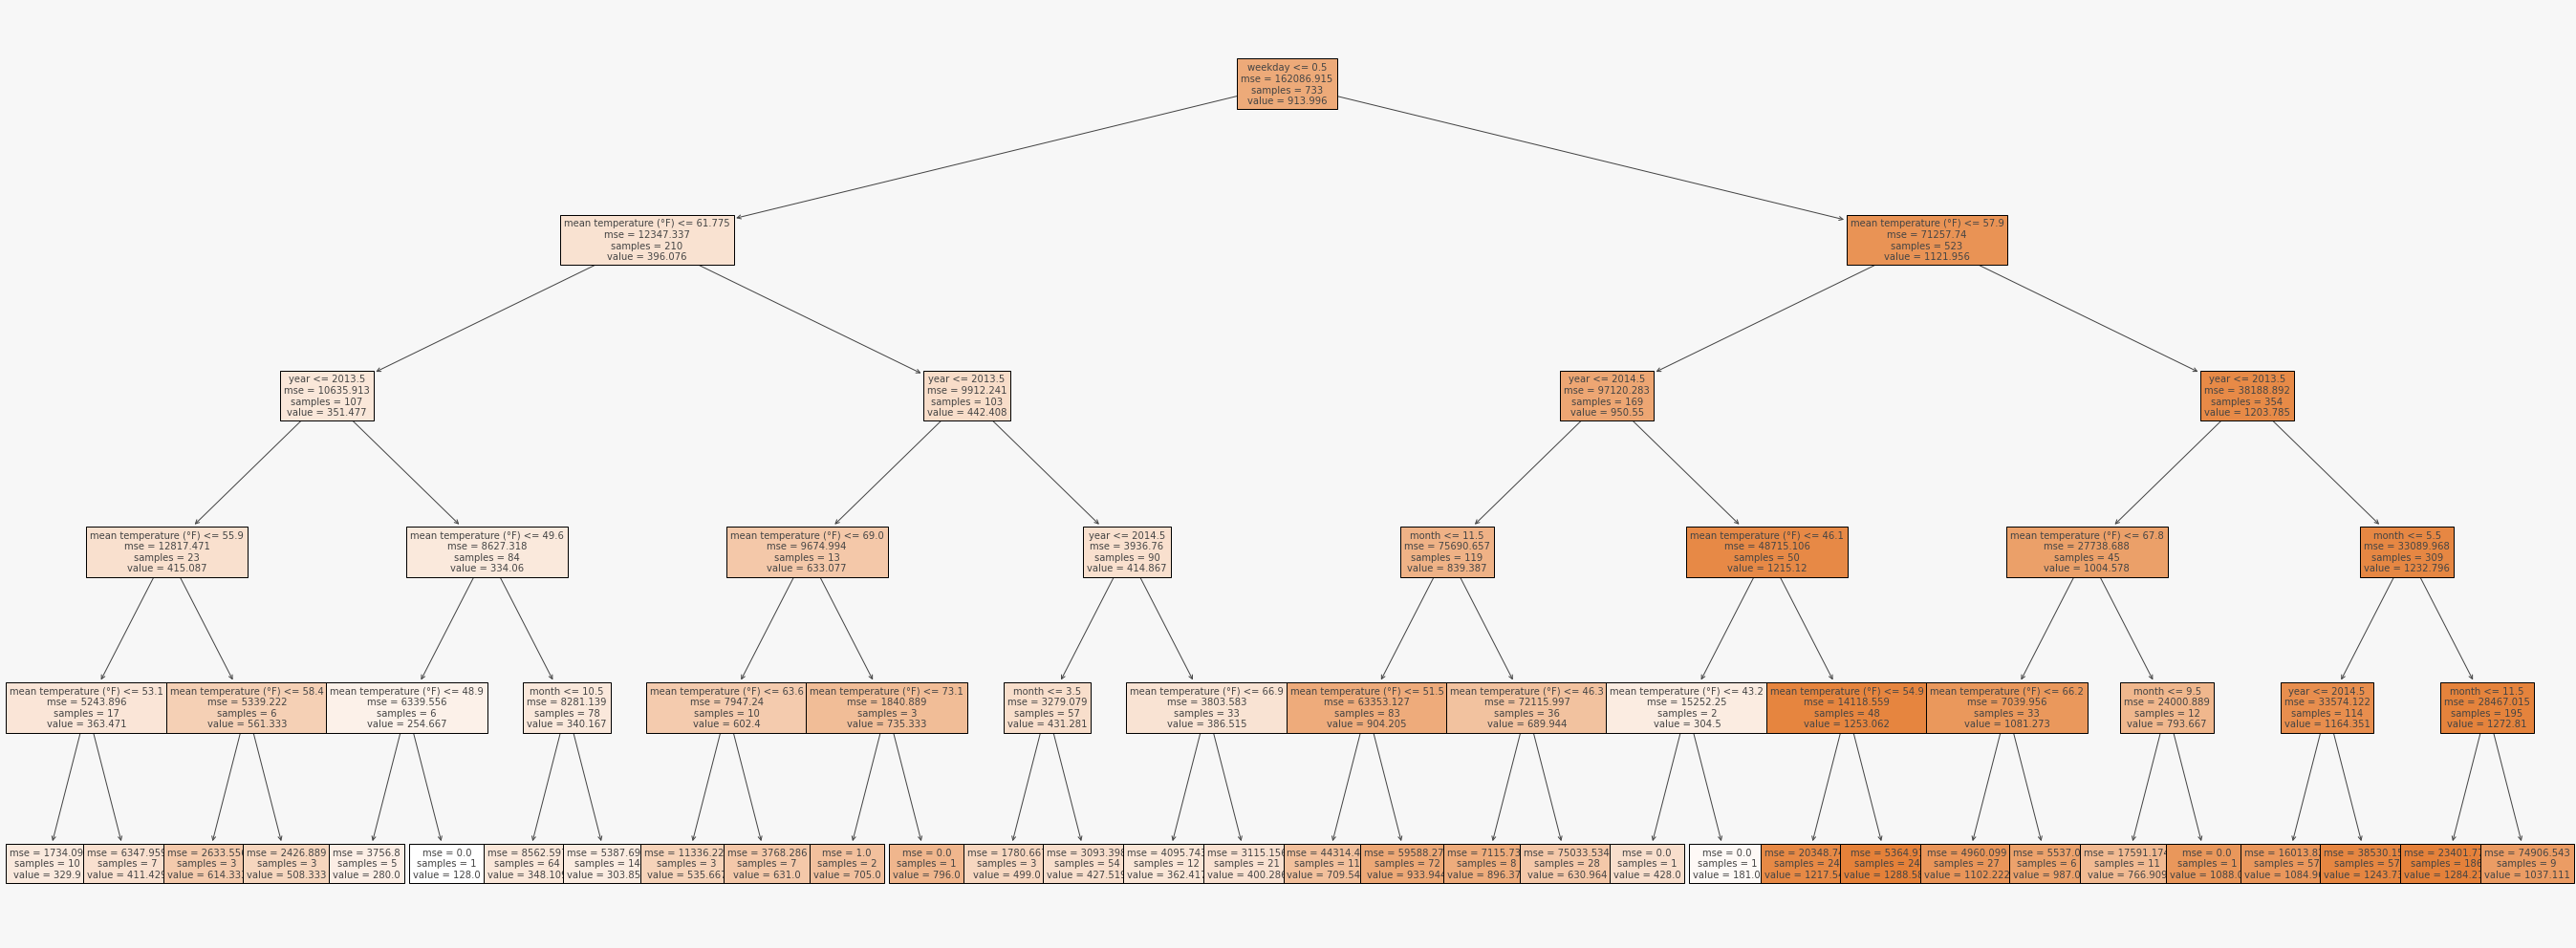

In [902]:
trip_weather = trip_weather.rename(columns={"mean_temperature_f": "mean temperature (°F)"})
X = trip_weather[["weekday", "year", "month", "mean temperature (°F)"]].copy()
for col in list(X):
    X[col] = X[col].astype(float)

y = trip_weather[["num_trip"]].copy()

from sklearn import tree
sqft_tree = tree.DecisionTreeRegressor(max_depth=5).fit(X,y)
sqrf_fig = plt.figure(figsize=(48,18))
sqrf_fig = tree.plot_tree(sqft_tree, fontsize=10, feature_names=X.columns, filled=True)

The regression tree includes four variables, temperature, weekday, year, and month. The maximum depth of the tree is five. Thus there are 32  ($2^5$)  terminal nodes. Most terminal nodes include relatively small sample sizes. Increasing the tree size may encounter the issue of over-fitting. Weekday observations are predicted to have more bike trips per day, having a sample of 523. Suppose an observation is recorded on the weekend, having a temperature lower or equal to 53.1°F in 2013. In that case, it is predicted to be approximately 330 bike rental activities on that day with a mean square error o 1734.09. Many high mean square error above 1,000 indicates that the bias in the tree is significant. Since the larger the sample size, the more considerable the variation of the predicted value to the actual measurement. The tree predicts that the most number of daily trips to be on the weekday, with an average temperature between 54.9°F and 57.9°F in 2015, which we cannot observe from the linear regression.

## Conclusion

From August 2013 to August 2015, the average number of bike trips per day in the San Francisco Bay Area was 914. The number of bike rentals increased after June. We found that, on average, bike rental is higher from August to October. November to February are the coldest months, so bike rental activities are less frequent. The average temperature illustrates the number of trips differently compared to the month. When the weather is pleasant, people have high incentives to go for a bike ride. Much fewer individuals rent a bike in extreme weather such as below 50°F (10°C) or above 80°F (27°C). These two independent variables used to explain bike trips are correlated, which is reasonable since the day's temperature depends on the seasons. Separating weekday and weekend observations, we observe that the use of bikes shares significantly increased during weekdays. Bicycles are commonly used as a form of transportation on weekdays. 

The bike-share usage on weekdays and weekends may differ by the habit of weekday travellers and weekend travellers. The weekend is generally a rest time, so people rarely go out on weekends but prefer to go to work during the week, resulting in increased usage of bike shares. Despite the significant difference in bike share usage between weekdays and weekends, the number of daily trips on weekdays increased in 2015. Both groups observed a positive linear relationship between our dependent variable and the average temperature.

When we look more in-depth, observing the distribution of bike-sharing activities in 2013 and 2015 by zip codes informed us about the changes in the use of bikes and other details such as population. Most of the areas have an average annual bike rental of less than five, which indicates that there are zip code areas that add up to give us a maximum daily trip of 1516, from the summary statistics. Indeed, even some places are small but show a significantly high demand for bike shares. The most frequent bike rentals occur in San Francisco, implying that the bike share system is a more popular and well-known transportation method. Even though commute time for people in the Bay Area has been long since 2010, the driving rate in San Francisco has declined prominently (Castañeda, 2020). From 2013 to 2014, the San Francisco Bay Area population rose each year. The population was 3,298,000 in 2013, 3,304,000 in 2014, and 3,309,000. The annual increase in population was equal to or greater than 0.15%, a relatively small number but could contribute slightly to the rise of bike rentals (San Francisco Metro Area Population 1950-2022, n.d.).

Oil price could be a variable outside our data that influences bike-share usage. According to the gasoline price data from the U.S. Energy Information Administration, average oil prices in U.S. dollars per gallon decreased from 2013 to 2015. As the oil price rises, bike-share systems are used more often. In 2013, it was shown as a steeper slope than in other years between the relationship between daily trips and oil prices. The slope became flattered encountered by the decline in oil prices in 2015. Therefore, prices drove bike rentals less when cheaper, and vice versa.

The most suitable model to explain the variation in daily bike trips includes month, year, temperature, and weekday as predictors. After controlling for the month, year, and week of the day, a temperature of one Fahrenheit higher is associated with approximately eight extra bike trips per day. This is reasonable since people often go out for outdoor activities during warmer, mild climates rather than colder or extreme weather. Month and temperature are correlated, but after fixing the temperature, September and October have the highest number of bike trips per day, about 200 or more compared to December. People might have more vacations during these two months. The popularity of each year is also distinct. In 2015 the number of bike trips was, on average, 197 higher per day than in 2013. It is both statistically significant and economically significant. Weekday and weekend subgroups significantly differ on average weekday bike share usage was 726 per day more than on the weekend. We can infer that people from San Francisco Bay Area prefer to stay at home during weekends and are more active on weekdays. 

We discovered that weekday bike rental activities were significantly higher than on weekends. They may have different properties and can be observed as two distinguished subgroups. In the future, we want to add more variables to explain better the frequency of bike trips in the San Francisco Bay Area. Our current models have some lurking variables such as the air quality, the number of bus stations, and whether there is a shopping mall beside the bike share station. Adding these additional variables helps to explain the response better. Also, regression models can include some interaction terms, for example, year and temperature or month and temperature. 

In conclusion to our research, how often people use bike-share at the San Francisco Bay Area bike share does influence by the month and weather of the day. Bike-share rental activities are greatly affected by the day of the week and moderately influenced by the month or the temperature. San Francisco County is the most popular bike-share system, having a zip code area that reached an average number of trips per day of 130 in 2015. The month variable is also related to the gasoline price, and their relationship further induced our dependent variable to fluctuate.

<br />


## References

- Bay Area ZIP codes: Datasf: City and county of San Francisco. San Francisco Data. (n.d.). Retrieved March 22, 2022, from https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-ZIP-Codes/u5j3-svi6 
- California all grades all formulations retail gasoline prices (dollars per gallon). (n.d.). Retrieved March 21, 2022, from https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&amp;s=emm_epm0_pte_sca_dpg&amp;f=m 
- Martinez, Mark. "The impact weather has on NYC Citi Bike share company activity." Journal of Environmental and Resource Economics at Colby 4, no. 1 (2017): 12.
- Gebhart, Kyle, and Robert B. Noland. "The impact of weather conditions on bikeshare trips in Washington, DC." Transportation 41, no. 6 (2014): 1205-1225.
- Kaviti, Shruthi, Mohan M. Venigalla, Shanjiang Zhu, Kimberly Lucas, and Stefanie Brodie. "Impact of pricing and transit disruptions on bikeshare ridership and revenue." Transportation 47, no. 2 (2020): 641-662.
- San Francisco Metro Area Population 1950-2022. MacroTrends. (n.d.). Retrieved March 24, 2022, from https://www.macrotrends.net/cities/23130/san-francisco/population#:~:text=The%20current%20metro%20area%20population,a%200.15%25%20increase%20from%202021.
- Castañeda, L. (2020, January 11). How the Bay Area has changed since 2010. The Mercury News. Retrieved March 23, 2022, from https://www.mercurynews.com/2020/01/09/how-bay-area-demographics-have-changed-since-2010/